In [0]:
import pandas as pd
import unicodedata
import re
import io
import tensorflow as tf
from sklearn.model_selection import train_test_split
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
! wget --header="Host: www.manythings.org" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: http://localhost:8889/notebooks/A26%20seq%20models/Seq2SeqImplementation_Assignment.ipynb" --header="Cookie: __cfduid=d5d6483053d8f553a16e3797411e7fdb81587740885" --header="Connection: keep-alive" "http://www.manythings.org/anki/ita-eng.zip" -c -O 'ita-eng.zip'

--2020-05-08 10:22:07--  http://www.manythings.org/anki/ita-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.108.196, 104.24.109.196, 2606:4700:3037::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.108.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7345811 (7.0M) [application/zip]
Saving to: ‘ita-eng.zip’

ita-eng.zip         100%[===================>]   7.00M  3.73MB/s    in 1.9s    

2020-05-08 10:22:09 (3.73 MB/s) - ‘ita-eng.zip’ saved [7345811/7345811]



In [3]:
! unzip ita-eng.zip

Archive:  ita-eng.zip
  inflating: ita.txt                 
  inflating: _about.txt              


### Importing and processing the data

In [0]:
def unicode_to_ascii(s):
    
      return ''.join(c for c in unicodedata.normalize('NFD', s)
          if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):

    #w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [0]:
lines = io.open('ita.txt', encoding='UTF-8').read().strip().split('\n')

In [0]:
english=[]
spanish=[]
for n in range(0,len(lines)):
    a=lines[n]
    i=(a.find('CC-BY'))
    a=a[:i].split('\t')
    english.append(a[0])
    spanish.append(a[1])

In [0]:
processed_eng=[]
processed_spa=[]
for i,j in zip(english,spanish):
    temp=preprocess_sentence(i)
    processed_eng.append(temp)
    temp=preprocess_sentence(j)
    processed_spa.append(temp)

In [0]:
data=pd.DataFrame(list(zip(processed_eng, processed_spa)),columns =['English', 'Spanish'])

In [9]:
data.shape

(336614, 2)

In [10]:
data.head()

,English,Spanish
0,<start> Hi . <end>,<start> Ciao ! <end>
1,<start> Run ! <end>,<start> Corri ! <end>
2,<start> Run ! <end>,<start> Corra ! <end>
3,<start> Run ! <end>,<start> Correte ! <end>
4,<start> Who ? <end>,<start> Chi ? <end>


In [0]:
def tokenize(lang):
    
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

    return tensor, lang_tokenizer

In [0]:
english_tensor,english_tokenizer=tokenize(processed_eng)
spanish_tensor,spanish_tokenizer=tokenize(processed_spa)

#### train-test split for tensor and unporcessed sentences using same random seed. the latter will be used in evalyuation stage 

In [0]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(english_tensor, spanish_tensor, test_size=0.2,random_state=42)
input_train, input_val, target_train, target_val = train_test_split(english, spanish, test_size=0.2, random_state=42)

In [0]:
max_length_targ, max_length_inp = spanish_tensor.shape[1], english_tensor.shape[1]

### Setting Hyper parameters 

In [0]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(english_tokenizer.word_index)+1
vocab_tar_size = len(spanish_tokenizer.word_index)+1

#tf.data.Dataset.from_tensor.slices
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 53]), TensorShape([128, 55]))

### Defining classes for Encoder, Luong Attention, Decoder 

In [0]:
class Encoder(tf.keras.Model):
    
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)
        return output, state

    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class luongAttention(tf.keras.layers.Layer):
    
    def __init__(self, rnn_size,function_type):
        
        super(luongAttention, self).__init__()
        self.attention_func = function_type
        
        if self.attention_func == 'general':
            # General score function
            self.Wa = tf.keras.layers.Dense(rnn_size)
        elif self.attention_func == 'concat':
            # Concat score function
            self.Wa = tf.keras.layers.Dense(rnn_size, activation='tanh')
            self.va = tf.keras.layers.Dense(1)
        

    def call(self, query, values):
        
        #t=tf.expand_dims(query, 1)
        t=query
        
        if self.attention_func=='dot':
            #values:(batchsize,max_len,rnnsize)
            #query:(batchsize,1,rnnsize)
            #score:(batchsize,1,maxlen)
            score=tf.matmul(t, (values),transpose_b=True)
            #print(score.shape)

        if self.attention_func=='general':
            #values:(batchsize,max_len,rnnsize)
            #query:(batchsize,1,rnnsize)
            values=self.Wa(values) #shape=(batchsize,max_len,rnnsize)
            score=tf.matmul(t, (values),transpose_b=True) #shape=(batchsize,1,maxlen)
            #print(score.shape)
            
        if self.attention_func=='concat':
            
            t=tf.tile(t, [1, values.shape[1],1]) #broadcasting done; shape=(batchsize,maxlen,rnnsize)
            temp=tf.concat((t, values), axis=-1) #shape=(batchsize,maxlen,2*rnnsize)
            temp=self.Wa(temp)# shape=(batchsize,maxlen,rnnsize)
            score=self.va(temp)# shape=(batchsize,maxlen,1)
            score=tf.transpose(score,[0,2,1]) #shape=(batchsize,1,maxlen)
            #print(score.shape)
        
        alignment = tf.nn.softmax(score, axis=2)
        context = tf.matmul(alignment, values)

        return context, alignment
            


In [0]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, rnn_size,func):
        super(Decoder, self).__init__()
        
        self.attention = luongAttention(rnn_size,func)

        self.rnn_size = rnn_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.gru = tf.keras.layers.GRU(self.rnn_size,
                                        return_sequences=True,
                                        return_state=True,
                                        recurrent_initializer='glorot_uniform') 
        
        self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)

    def call(self, sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(sequence)
        
        # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
        #lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
        lstm_out, state = self.gru(embed,initial_state=state)
        
        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, rnn_size)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)
        
        
        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, rnn_size),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * rnn_size)
        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        
        # lstm_out now has shape (batch_size, rnn_size)
        lstm_out = self.wc(lstm_out)
        logits = self.ws(lstm_out)
        #print(logits.shape)
       
        
        return logits,state,alignment
        
        

In [0]:
optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

#### Train step function uses training data to make predictions using teacher forcing and find gradients for the weights

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden):
    
    loss = 0

    with tf.GradientTape() as tape:
        
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([spanish_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        for t in range(1, targ.shape[1]):
            
            #passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

#### Instatiating encoder and decoder classes

In [0]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder=Decoder(vocab_tar_size, embedding_dim, units,"general")

In [0]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training for 10 epochs

In [24]:
EPOCHS = 10

for epoch in range(EPOCHS):
    
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
        
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        
        checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.3552
Epoch 1 Batch 100 Loss 0.7445
Epoch 1 Batch 200 Loss 0.7167
Epoch 1 Batch 300 Loss 0.7462
Epoch 1 Batch 400 Loss 0.6462
Epoch 1 Batch 500 Loss 0.6255
Epoch 1 Batch 600 Loss 0.6710
Epoch 1 Batch 700 Loss 0.7070
Epoch 1 Batch 800 Loss 0.7163
Epoch 1 Batch 900 Loss 0.6494
Epoch 1 Batch 1000 Loss 0.6367
Epoch 1 Batch 1100 Loss 0.5149
Epoch 1 Batch 1200 Loss 0.5356
Epoch 1 Batch 1300 Loss 0.5138
Epoch 1 Batch 1400 Loss 0.4658
Epoch 1 Batch 1500 Loss 0.4180
Epoch 1 Batch 1600 Loss 0.4129
Epoch 1 Batch 1700 Loss 0.3972
Epoch 1 Batch 1800 Loss 0.3689
Epoch 1 Batch 1900 Loss 0.3922
Epoch 1 Batch 2000 Loss 0.3377
Epoch 1 Batch 2100 Loss 0.3195
Epoch 1 Loss 0.5682
Time taken for 1 epoch 1536.6585760116577 sec

Epoch 2 Batch 0 Loss 0.3097
Epoch 2 Batch 100 Loss 0.3267
Epoch 2 Batch 200 Loss 0.2870
Epoch 2 Batch 300 Loss 0.2333
Epoch 2 Batch 400 Loss 0.2327
Epoch 2 Batch 500 Loss 0.2569
Epoch 2 Batch 600 Loss 0.2431
Epoch 2 Batch 700 Loss 0.2258
Epoch 2 Batch 800 Loss 0.

In [0]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  inputs = [english_tokenizer.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  hidden = [tf.zeros((1, units))]
  enc_out, enc_hidden = encoder(inputs, hidden)

  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([spanish_tokenizer.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += spanish_tokenizer.index_word[predicted_id] + ' '

    if spanish_tokenizer.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [0]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [0]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Making predictions for few sentences and plotting its attention plot

Input: <start> he went out in a hurry . <end>
Predicted translation: lui usc di fretta . <end> 


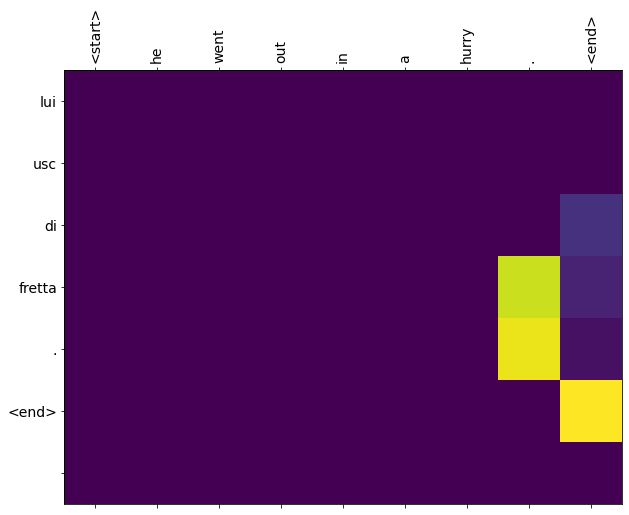

In [28]:
translate(input_val[20].lower())

Input: <start> i gave my old coat to tom . <end>
Predicted translation: ho dato il mio vecchio cappotto a tom . <end> 


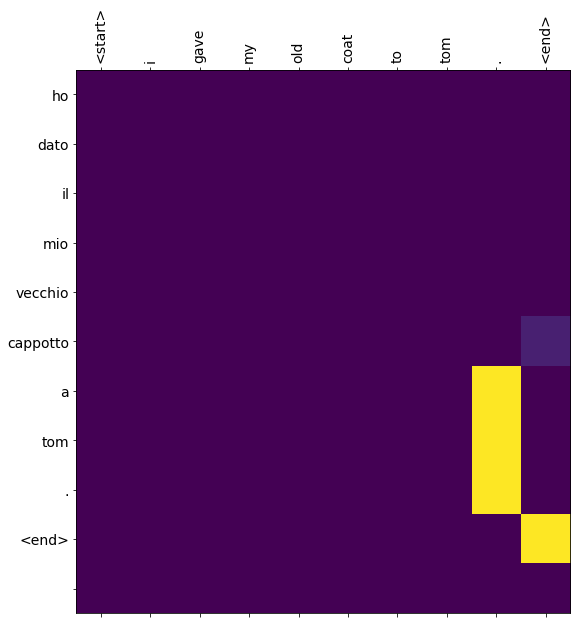

In [29]:
translate(input_val[99].lower())

Input: <start> you were supposed to be prepared . <end>
Predicted translation: dovevate essere preparati . <end> 


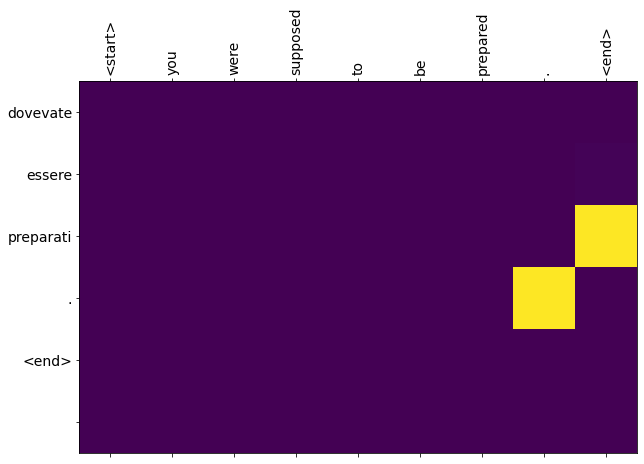

In [30]:
translate(input_val[63].lower())

Input: <start> we captured the thief . <end>
Predicted translation: noi abbiamo avuto un ladro . <end> 


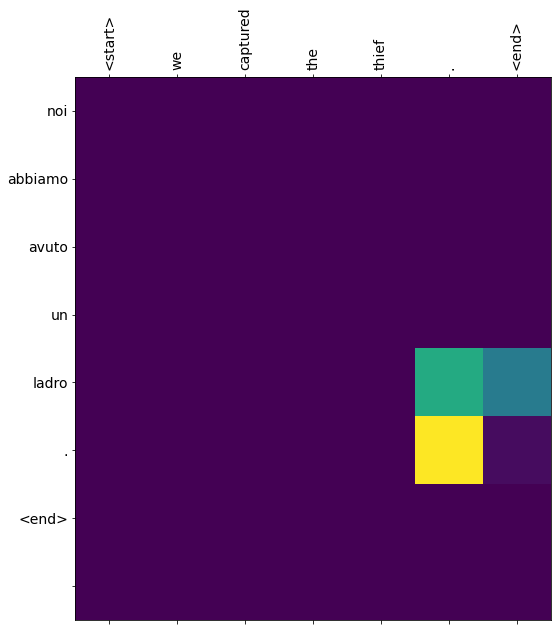

In [31]:
translate(input_val[62].lower())

Input: <start> tom knew certain things about mary that she hoped he wouldn t tell john . <end>
Predicted translation: tom sapeva cose che a mary non dire che non aveva ragione a dire che john . <end> 


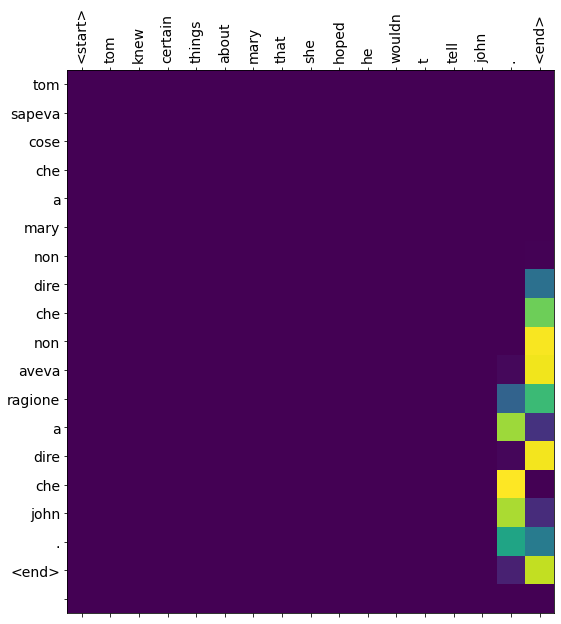

In [32]:
translate(input_val[763].lower())

### Calculating BLEU score for test data

In [0]:
def pre(w):
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w=w.lower()
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    w = w.strip()
    return w

In [0]:
import nltk.translate.bleu_score as bleu
from tqdm import tqdm_notebook
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [35]:
l=np.zeros((len(input_val),3),dtype=object)
i=0
for inp,tar in tqdm_notebook(zip(input_val,target_val)):
  x,_,_=evaluate(inp.lower())
  translation=x[:-7].split(" ")
  l[i,0]= x[:-7]
  reference=pre(tar)
  l[i,1]= reference
  reference=[reference.split(" ")]
  l[i,2]= bleu.sentence_bleu(reference, translation)
  i+=1
  

In [0]:
df = pd.DataFrame(l, columns = ['translation','reference','BLEU'])

In [37]:
df.head(10)

,translation,reference,BLEU
0,il processo di tom durato tre giorni .,il processo di tom durato tre giorni .,1
1,ha iniziato a scrivere un romanzo .,lui ha iniziato a scrivere un romanzo .,0.866878
2,riposiamoci qua .,riposiamoci qui .,0.903602
3,sono le dieci e mezza ?,sono circa le dieci ?,0.604275
4,tom era sposato allora .,tom era sposato all epoca .,0.494739
5,mettete quella pistola .,metti gi quella pistola .,0.550695
6,ai bambini piace gli orsetti gommosi .,ai bambini piacciono gli orsetti gommosi .,0.488923
7,io lo devo dire a tom .,io lo devo dire a tom .,1
8,sapevo che questo momento sarebbe venuto .,sapevo che questo momento sarebbe arrivato .,0.643459
9,non ho detto a nessuno .,io non ho incontrato nessuno .,0.718608


In [38]:
score=df["BLEU"].mean()
print("Average BLEU score:",score)

Average BLEU score: 0.6760241527833699


## Conclusions:

1. This model implents english to italian translation using luong attetion(using general score)
2. The model used 512 hidden units for GRU cell,256 as embedding dimension, batch size of 128
3. The model was trainied for 10 epochs and achieved a cross entopy loss of 0.0581 on train data
4. The model was validated for 67,000 instances(test data) and achieved a BLEU score of 0.6760